# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [15]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)


**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [41]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]


from ema_workbench import MultiprocessingEvaluator
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging
from ema_workbench.em_framework import samplers

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 500
n_policies = 4

scenarios = samplers.sample_levers(lake_model, n_scenarios, sampler=samplers.MonteCarloSampler())

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(scenarios, n_policies)



[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [42]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-5))]

In [43]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers',
                                    epsilons=[0.125, 0.05, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 92 solutions
[MainProcess/INFO] terminating pool


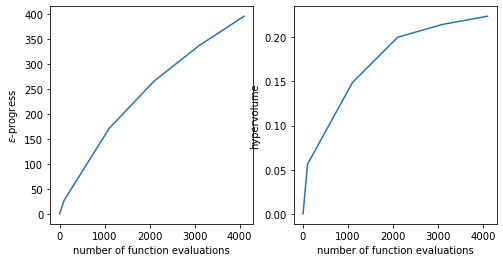

In [44]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?

In [ ]:
"""
for signal to noise:

import numpy as np
import functools
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

from ema_workbench.em_framework.samplers import sample_uncertainties

def signal_to_noise(data):
    mean = np.mean(data)
    std = np.std(data)
    sn = mean/std
    return sn

percentile10 = functools.partial(np.percentile, q=10)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE
robustnes_functions = [ScalarOutcome('mean p', kind=MINIMIZE, variable_name='max_P', function=np.mean),
                       ScalarOutcome('std p', kind=MINIMIZE, variable_name='max_P', function=np.std),
                       ScalarOutcome('sn reliability', kind=MAXIMIZE, variable_name='reliability', function=signal_to_noise),
                      ScalarOutcome('10th percentile utility', kind=MAXIMIZE, variable_name='reliability', function=percentile10),
                      ]

n_scenarios = 10
scenarios = sample_uncertainties(lake_model, n_scenarios)
nfe = 1000

with MultiprocessingEvaluator(lake_model) as evaluator:
    robust_results = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe, population_size=25, epsilons=[0.1,]*len(robustnes_functions))

"""

